# Homework #1 - K-nearest neighbors method

Today we will implement our first machine learning algorithm, the K-nearest neighbors method. We will try to solve problems with it:
- binary classification (that is, only two classes)
- multi-class classification (that is, several classes)
- regressions (when the dependent variable is a natural number)

Since the method needs a hyperparameter - the number of neighbors, we need to learn how to select this parameter. We will try to learn how to use numpy for vectorized calculations, and also look at several metrics that are used in classification and regression problems.

Before completing the task:
- install all required libraries by running `pip install -r requirements.txt`

If you have not worked with numpy before or have forgotten it, then you can remember here:
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy, r_squared, mse, mae

import warnings
warnings.filterwarnings('ignore') 

%load_ext autoreload
%autoreload 2

In [41]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Task 1. KNN on the Fashion-MNIST dataset

In this task you have to work with pictures of clothes, among which 10 classes can be distinguished. The data is already loaded for you: the X variable contains 70,000 28 x 28 pixel images flattened into a 784 (28 * 28) vector. Since there is quite a lot of data, and our KNN will be very slow, we will randomly take 1000 observations (in reality, depending on your implementation, you can take more, but if there is no RAM, then take less).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)
y = y.astype(np.int)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Let's look at some image from our data:

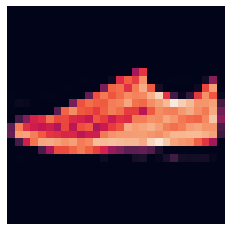

In [5]:
# take a random picture and do a reshape
# 28, 28, 1 = H, W, C (number of channels, in this case 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28)
plt.imshow(image)
plt.axis("off");

### 1.1. Let's look at all classes

Take one picture of each class and draw them (for example, make subplots 5 by 2).

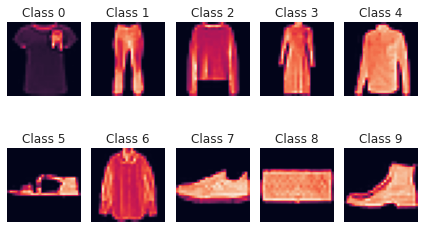

In [6]:
fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, ax in enumerate(axs):
    index = np.where(y==i)[0][0]
    image = X[index].reshape(28, 28)
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Class {i}")
fig.tight_layout()

### 1.2. Make a small EDA

Look at class balance. In the following homework, do EDA whenever you cinsider it needed But it is almost always needed :).Do EDA to learn something new about data!

In [7]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 93, 1: 102, 2: 95, 3: 121, 4: 96, 5: 98, 6: 101, 7: 79, 8: 109, 9: 106}

For me it was
{'0': 93,
  '1': 102
  '2': 95
  '3': 121
  '4': 96
  '5': 98
  '6': 101
  '7': 79,
  '8': 109
  '9': 106}
  Quite balanced, Slightly different are '3' and '7' classes

### 1.3. Divide the data into train and test

Divide the data into training and test sets, choose the size of the test set yourself. This is where the `train_test_split` function can help you.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1.4. KNN for Binary Classification

Let's take for the binary classification problem only objects with class labels 0 and 1.

In [9]:
idx_mask = np.logical_or(y_train == 0, y_train == 1)
binary_train_X, binary_train_y = X_train[idx_mask], y_train[idx_mask]
idx_mask = np.logical_or(y_test == 0, y_test == 1)
binary_test_X, binary_test_y = X_test[idx_mask], y_test[idx_mask]

And so we prepared the data, but we don’t have a model yet. In several lessons of our course, you will have to implement some machine learning algorithms yourself, and then compare them with ready-made library solutions. In the rest of the tasks, it will not be necessary to implement algorithms, but it can be useful, so often these will be tasks for additional points, but this is not the main thing, but understanding the operation of the algorithm after its implementation from scratch using simple numpy. Also, all this can then be arranged in the form of the `ml_from_scratch` repository and brag to your friends.

In [10]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### It's time to code!

In KNN, for each test case, we need to find the distances to all points of the training sample. Let's say we have 1000 examples in train and 100 in test, then in the end we would like to get a matrix of pairwise distances (for example, 100 by 1000). This can be done in several ways, and someone probably comes up with the idea of two nested loops (I hope not more :).But there are better ways. In general, the real KNN uses the [k-d-tree](https://en.wikipedia.org/wiki/K-d_tree) data structure, which allows you to search for log (N), and not for N, as we will do (in fact, this is an extension of binary search to a multidimensional space).

You will need to implement the `compute_distances_two_loops`, `compute_distances_one_loop` and `compute_distances_no_loops` methods of the `KNN` class in the `knn.py`.

These functions build an array of distances between all vectors in the test set and in the training set.
As a result, they must build an array of size `(num_test, num_train)`, where the coordinate `[i][j]` corresponds to the distance between the i-th vector in test (`test[i]`) and the j-th vector in train ( `train[j]`).

**Please note** For ease of implementation, we will use the L1 measure as the distance (it is also called [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

In the beginning, I will sometimes write different asserts so that you can check the correctness of the implementation, in the future you will need to write them yourself if you need to check the correctness of some calculations.

In [11]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [12]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Check the speed of the implemented methods

In [14]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)
### Strange. Apparently this is not the optimal way for no_loops. Works worse than one loop

74.9 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.3 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.1 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Implementing a Method to Predict Class Labels

In [15]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X, n_loops=2)

### Metrics

Now we need to implement some metrics for binary classification. Don't forget to think about numerical instability (divide by 0).

In [16]:
# TODO: binary_classification_metrics in metrics.py

In [17]:
metrics_name = ['precision', 'recall', 'f1 score', 'accuracy']
metrics_val = binary_classification_metrics(prediction, binary_test_y)
for i, val in enumerate(metrics_val):
    print(f'{metrics_name[i]}: \t{val}')

precision: 	1.0
recall: 	1.0
f1 score: 	1.0
accuracy: 	1.0


Is everything okay with the model? You can test your implementation with functions from the `sklearn` library:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
sklearn_metrics = [precision_score, recall_score, f1_score, accuracy_score]
for metric in sklearn_metrics:
    print(f'{metric.__name__}: {metric(binary_test_y, prediction)}')


precision_score: 1.0
recall_score: 1.0
f1_score: 1.0
accuracy_score: 1.0


### Selection of the optimal k

To select the optimal value of the parameter k, you can do the following: specify the range of acceptable values for k, for example, `[1, 3, 5, 10]`. Then, for each k, train the model on the training data, make predictions on the test data, and calculate some metric (choose the metric yourself based on the task, but try to justify the choice). At the end, you need to look at the dependence of the metric on train and test on k and choose the appropriate value.

Implement the `choose_best_k` function directly in the notebook.

In [19]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics, test_metrics = np.array([]), np.array([])
    for k in params:
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        prediction_test = knn_classifier.predict(X_test, n_loops=1)
        prediction_train = knn_classifier.predict(X_train, n_loops=1)
        test_metrics = np.append(test_metrics, metric(y_test, prediction_test))
        train_metrics = np.append(train_metrics, metric(y_train, prediction_train))
    return train_metrics, test_metrics

In [20]:
params = range(1,31)

train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

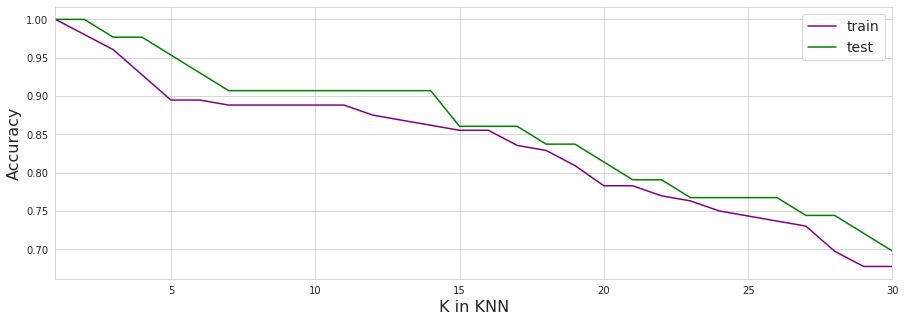

In [21]:
plt.figure(figsize=(15,5))
plt.plot(params, train_metrics, label="train", color ='purple')
plt.plot(params, test_metrics, label="test", color ='green')
plt.xlim(1, 30)
plt.legend(fontsize=14)
plt.xlabel("K in KNN", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

<font color="#3059C1">(2/6)</font>

**As long as it is a binary classification with balanced classes, we have decided to use accuracy score.**

**k=3 it's a maximal k with still maximumum accuracy for test. We will proceed with tgis one. Yet any k up to 14-15 looks good enough, if k=3 will be considered inadequate later on**

Actually, this is not the best way to fit hyperparameters, but we will look at better ways next time, but for now, choose the optimal value of k, make predictions and see how well your model predicts each of the classes.

### 1.5. Multiclass classification 

Now you need to learn how to predict all 10 classes. To do this, at the beginning we will write the corresponding method for our classifier.

In [22]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

In [23]:
predictions == y_test

array([ True, False,  True,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False, False, False,  True,  True,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,

It remains to implement the quality metric for multiclass classification, for this, implement the `multiclass_accuracy` function in `metrics.py`.

In [24]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.76

In [25]:
params = range(1,31)
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, multiclass_accuracy)

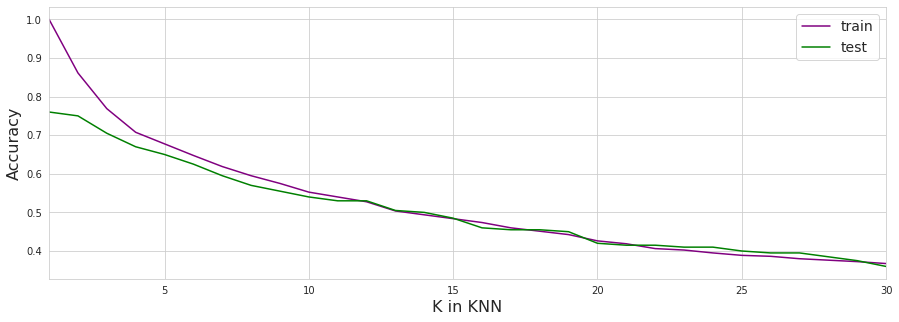

In [26]:
plt.figure(figsize=(15,5))
plt.plot(params, train_metrics, label="train", color ='purple')
plt.plot(params, test_metrics, label="test", color ='green')
plt.xlim(1, 30)
plt.legend(fontsize=14)
plt.xlabel("K in KNN", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

Again choose the optimal value of K as we did for binary classification.

**Well, it's hard to pint out the best one, so I will go with k=3? at wich accuracy is still over 0.7*

## Task 2.KNN on diabetes dataset

Now let's try to apply KNN to the regression problem. We will work with diabetes [data](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset). In this task, we will use the `KNeighborsRegressor` class from the `sklearn` library. Download the required libraries:

In [70]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [29]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


* age age in years
* sex
* bmi body mass index
* bp average blood pressure
* s1 tc, total serum cholesterol
* s2 ldl, low-density lipoproteins
* s3 hdl, high-density lipoproteins
* s4 tch, total cholesterol / HDL
* s5 ltg, possibly log of serum triglycerides level
* s6 glu, blood sugar level

### 2.1. EDA 

Make an EDA, preprocess the data as you see fit, is standardization needed in this case and why? Do not forget that if you are standardizing the data, then you need to calculate the mean and standard deviation on the training part and use them to transform both train and test (**if you don’t understand this sentence, then be sure to figure it out**).

**Additionally**:
Try to figure out [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) so that you can create a class that immediately standardizes and trains the model (or does prediction). Pipelines are very convenient when you need to apply different data preprocessing methods (including to different columns), and they also allow you to correctly integrate data preprocessing into various classes to find the best model hyperparameters (for example, `GridSearchCV`).

In [30]:
print('________description for X________\n')
X.info()
print('\n________description for y________\n')
y.info()
print(f'\n{X.shape=}, {y.shape=}')

________description for X________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB

________description for y________

<class 'pandas.core.series.Series'>
RangeIndex: 442 entries, 0 to 441
Series name: target
Non-Null Count  Dtype  
--------------  -----  
442 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB

X.shape=(442, 10), y.shape=(442,)


In [31]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


In [32]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

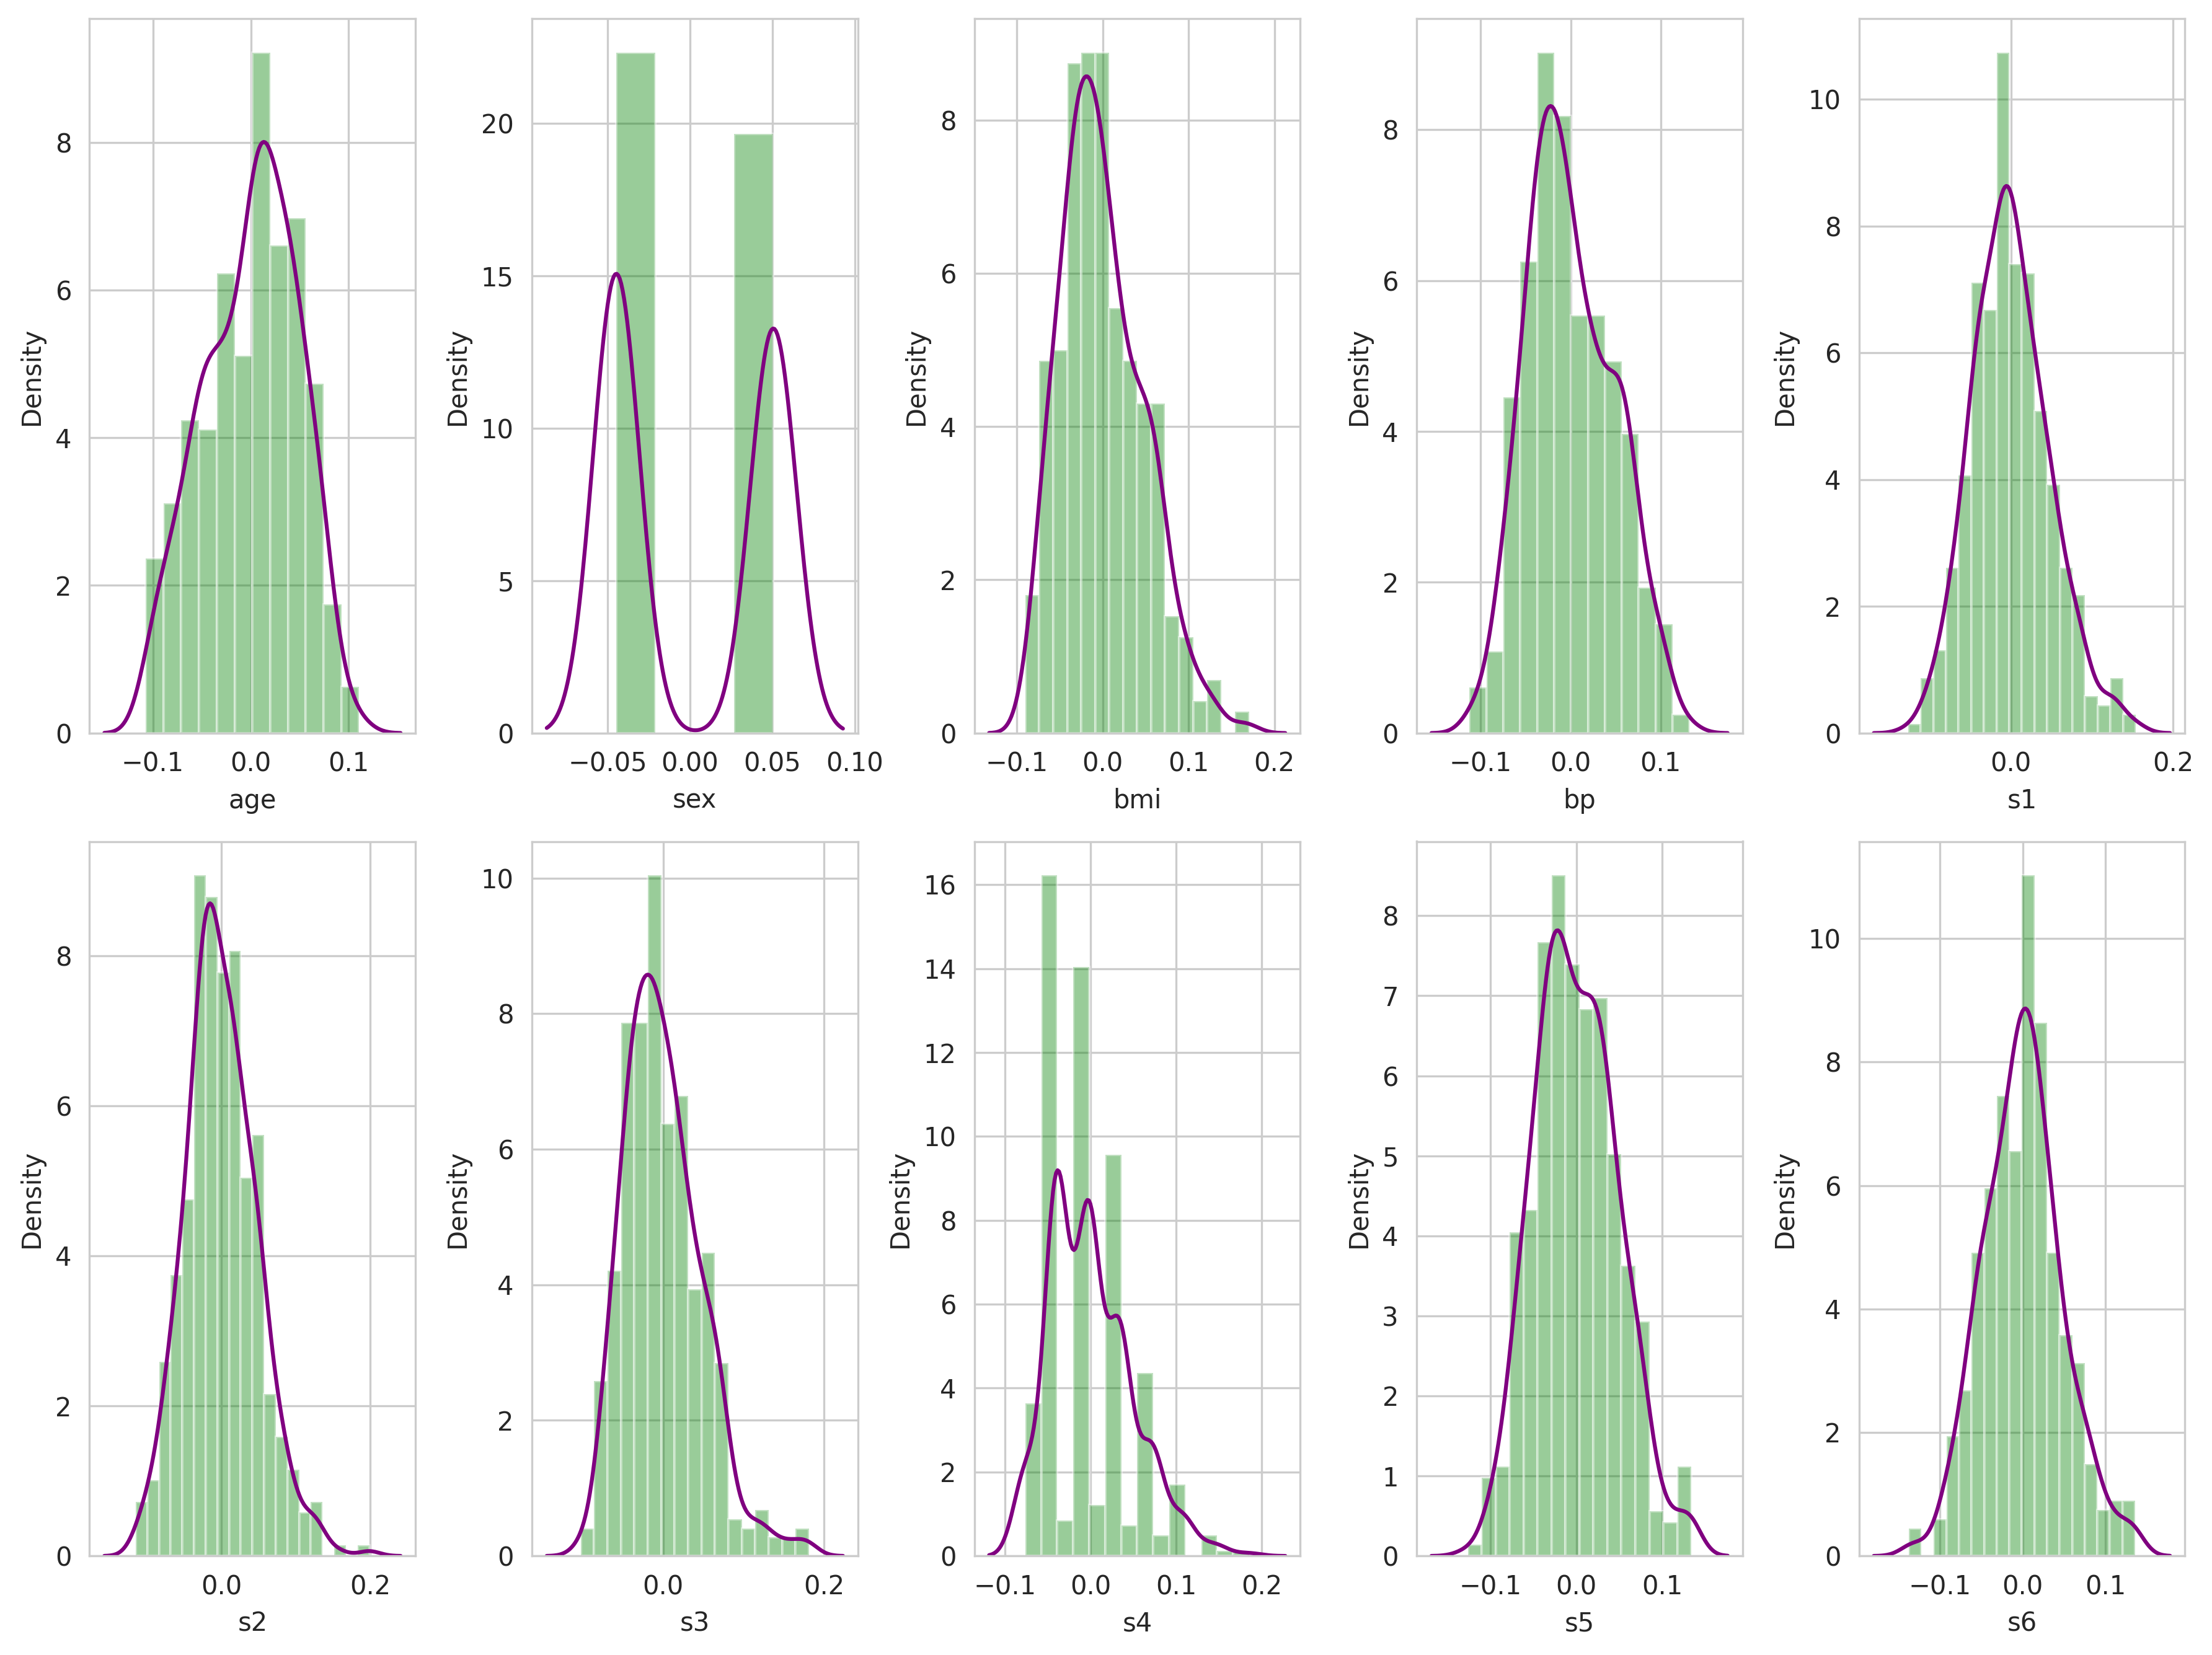

In [47]:
fig, axs = plt.subplots(2, 5, dpi=300)
axs = axs.ravel()

for i, ax in enumerate(axs):
    sns.distplot(X.iloc[:,i], ax=ax, color='green')
    ax.lines[0].set_color('purple')
fig.tight_layout()



**Source of dataset says data is standardized. And it really looks like it. Yet, after train/test split I'll perfrom aonther standartization and will apply OHE to sex column**

Text(0.5, 1.0, 'Target distribution')

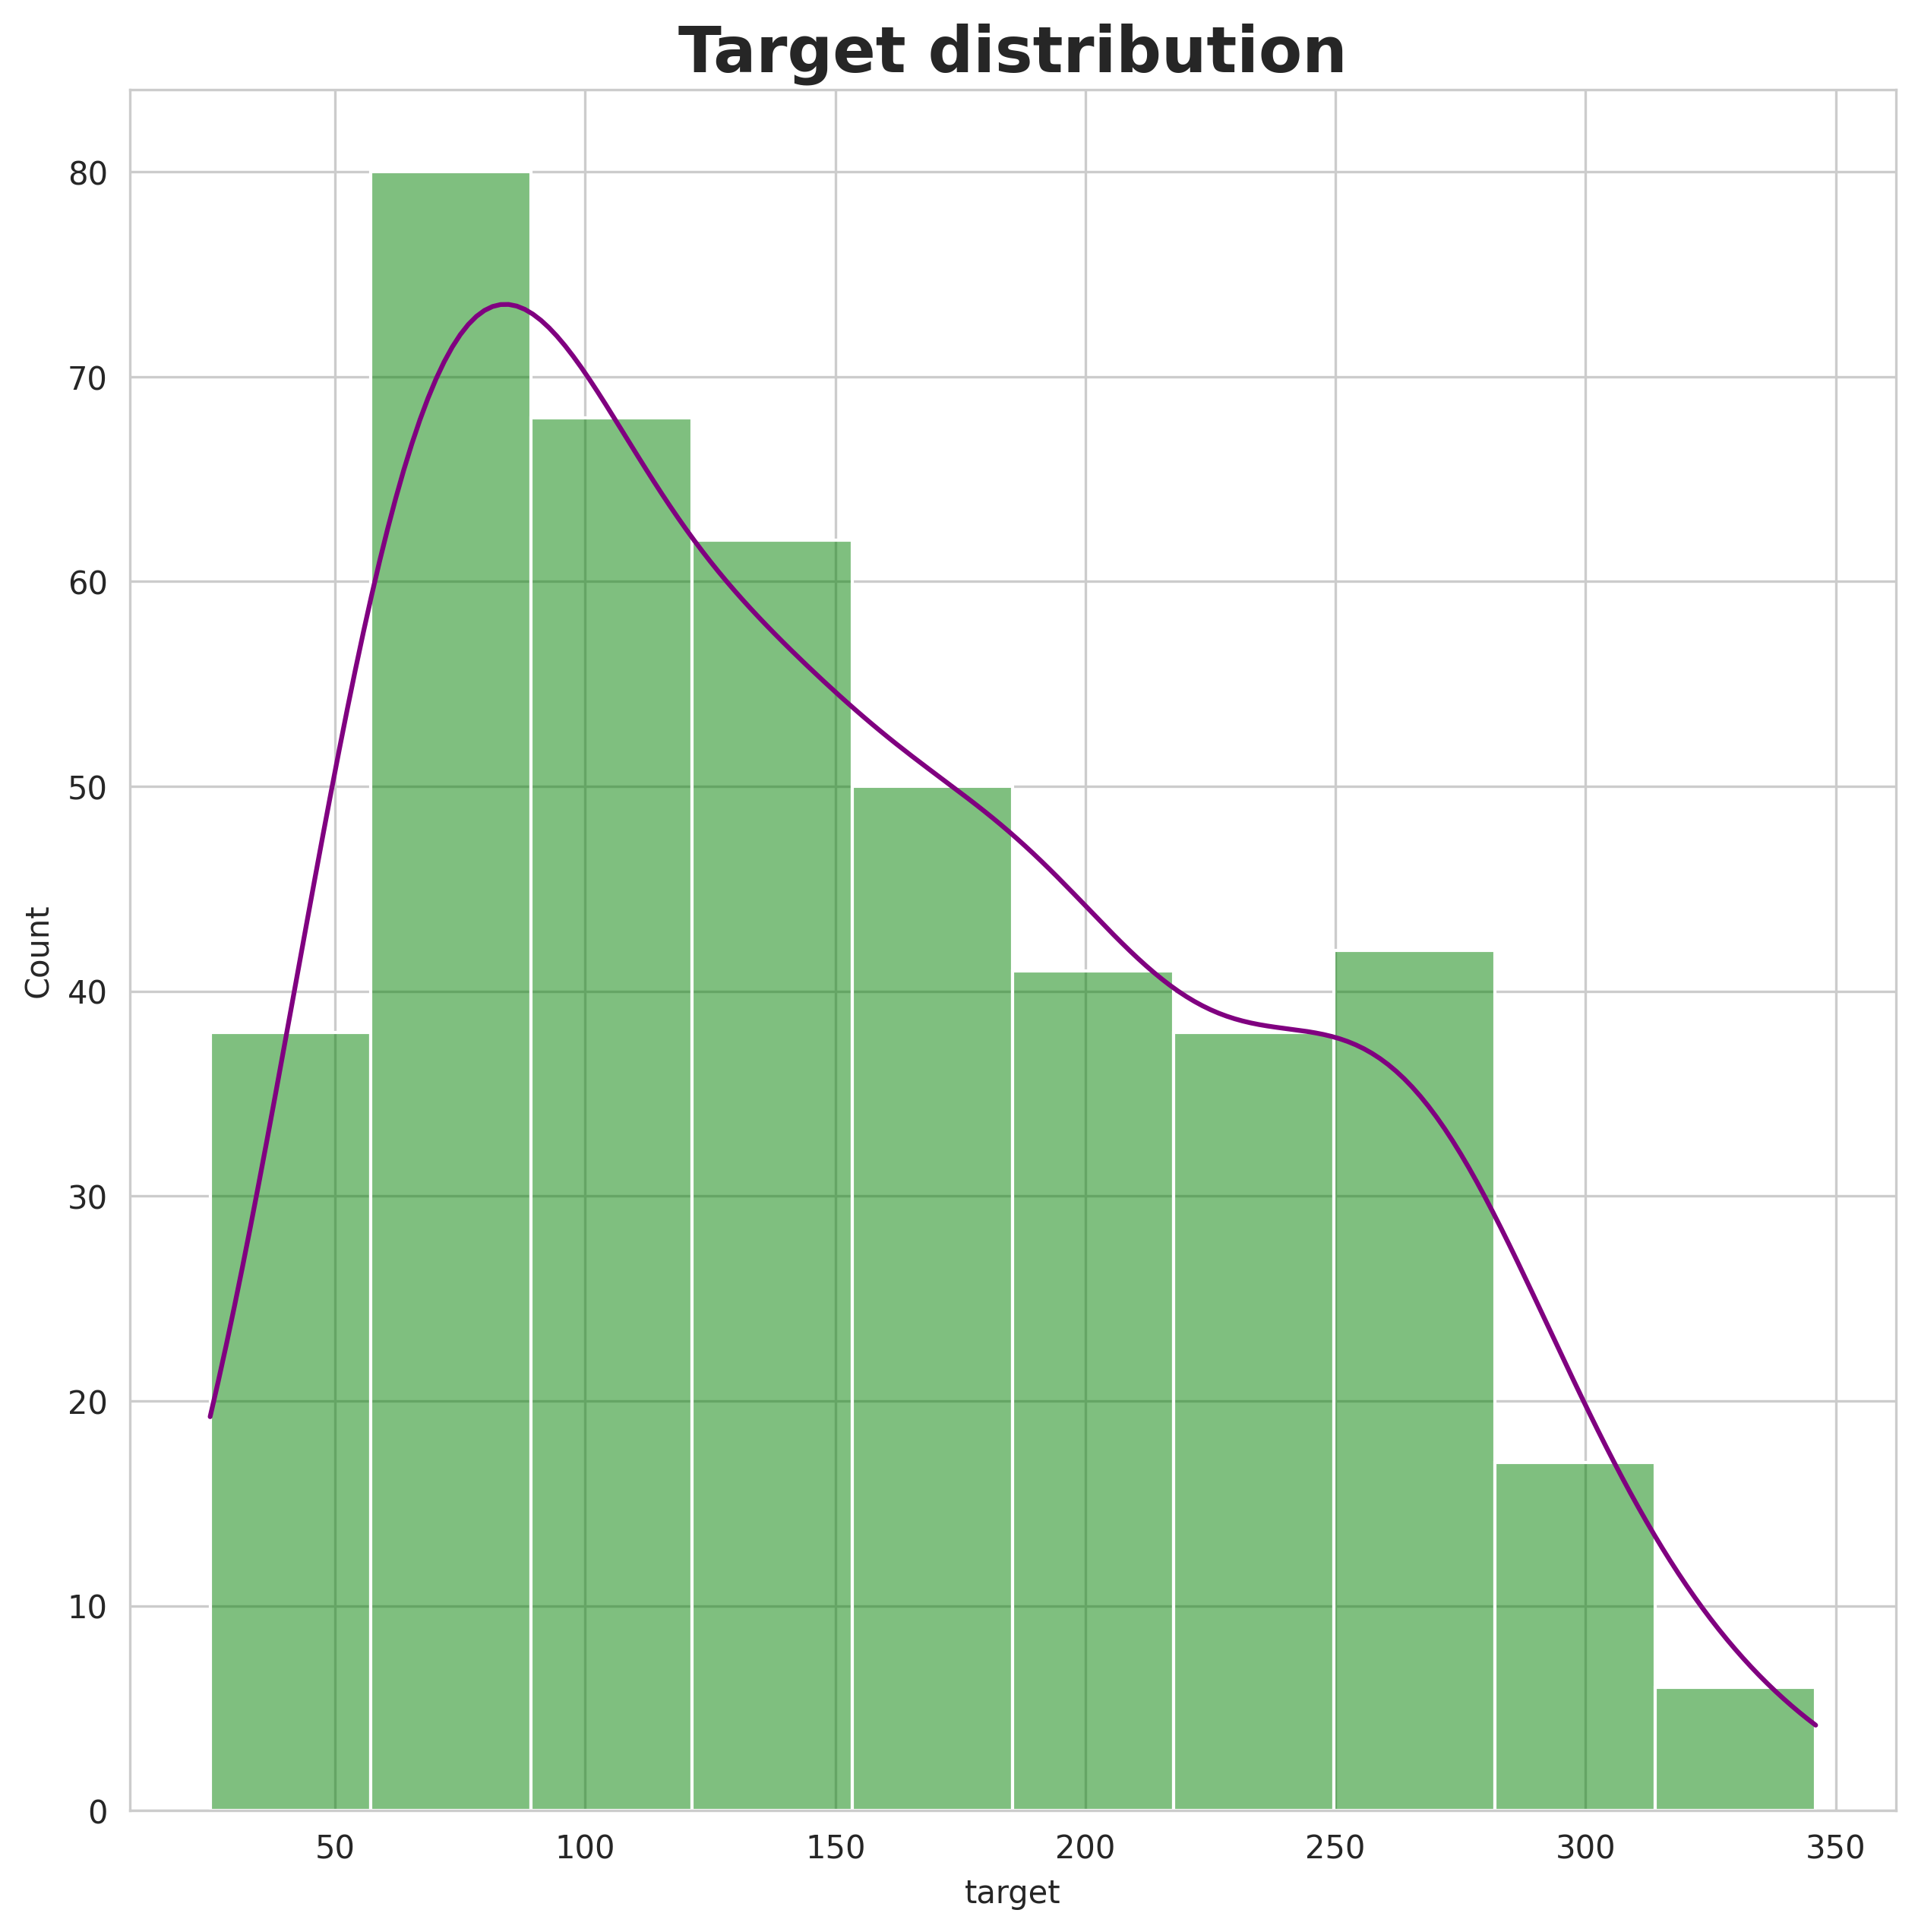

In [68]:
# histplot for target
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=300)
sns.histplot(y, kde=True, ax=ax, color='green')
ax.lines[0].set_color('purple')
ax.set_title("Target distribution", fontsize=20, fontweight='bold')

**Don't know how important this is for regression, the target variable is unevenly distributed.**

### 2.2.Regression model + Pipeline(optional)

Create a `KNeighborsRegressor` model, train it on the training data and make predictions.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
cat_col = ["sex"]
num_cols = ["age", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]

In [73]:
transformer = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_col)
])

transformer.transformers

[('scaler',
  StandardScaler(),
  ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']),
 ('ohe', OneHotEncoder(drop='first'), ['sex'])]

In [74]:
regression_pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("knn", KNeighborsRegressor(n_neighbors=1, n_jobs=3, metric="manhattan"))
])

In [75]:

regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'bp', 's1',
                                                   's2', 's3', 's4', 's5',
                                                   's6']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex'])])),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_jobs=3,
                                     n_neighbors=1))])

In [76]:
prediction = regression_pipeline.predict(X_test)

### 2.3. Regression Metrics

Implement $R^2$, MSE and MAE metrics in `metrics.py`. Apply them to evaluate the quality of the resulting model. Is everything alright?

Let me remind you that:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [61]:
# TODO: r_squared, mse, mae in metrics.py

In [87]:
print(f'My r2: {r_squared(y_test,prediction):.4f},   \tsklearn r2: {r2_score(prediction,y_test):.4f}')
print(f'My mse: {mse(y_test,prediction):.4f}, \tsklearn mse: {mean_squared_error(prediction,y_test):.4f}')
print(f'My mae: {mae(y_test,prediction):.4f}, \tsklearn mae: {mean_absolute_error(prediction,y_test):.4f}')

My r2: 0.0626,   	sklearn r2: 0.0626
My mse: 5205.2472, 	sklearn mse: 5205.2472
My mae: 55.7191, 	sklearn mae: 55.7191


### 2.4. Selection of the optimal number of neighbors

We've almost reached the end. Now it remains to choose the best number of neighbors for our model using the metrics we implemented.

!!! Pay attention to what our metrics mean, for some it is good when they decrease, for others it is not.

In [88]:
from metrics import r_squared, mse, mae

In [64]:
def find_best_k_regr(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics, test_metrics = np.array([]), np.array([])
    for k in params:
        knn_regr = KNeighborsRegressor(k)
        knn_regr.fit(X_train, y_train)
        prediction_test = knn_regr.predict(X_test)
        prediction_train = knn_regr.predict(X_train)
        test_metrics = np.append(test_metrics, metric(y_true=y_test, y_pred=prediction_test))
        train_metrics = np.append(train_metrics, metric(y_true=y_train, y_pred=prediction_train))
    return train_metrics, test_metrics

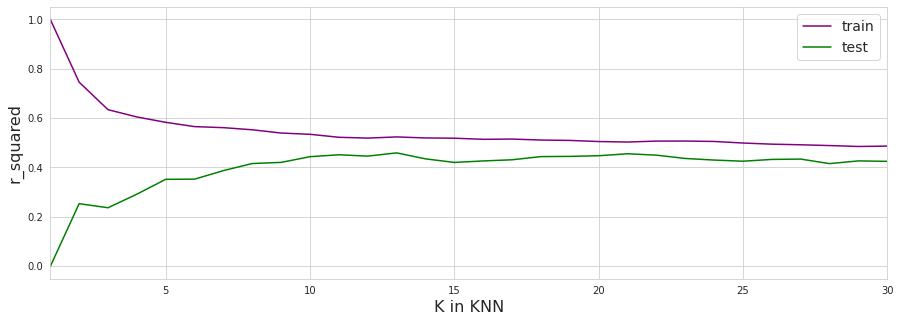

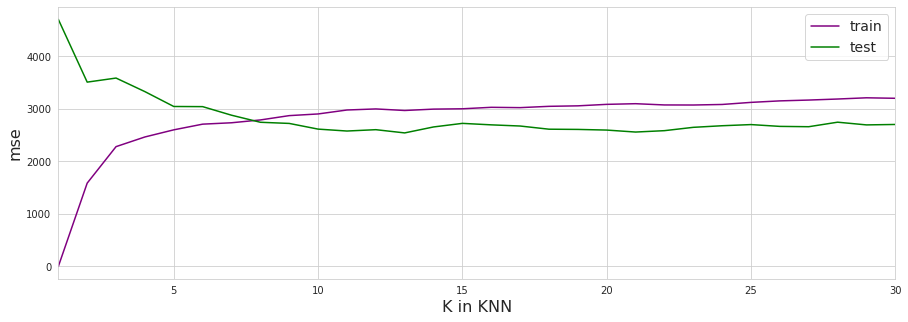

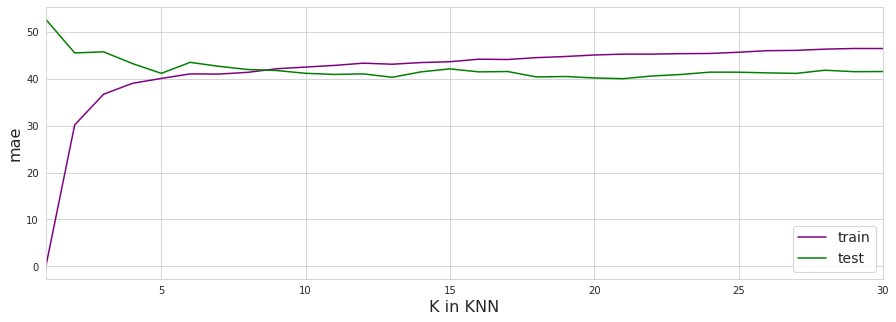

In [92]:
params = range(1,31)
metrics = [r_squared, mse, mae]
# fig, axs = plt.subplots(3, 1, dpi=300)
# axs = axs.ravel()
for i, ax in enumerate(axs):
    train_metrics, test_metrics = find_best_k_regr(X_train, y_train, X_test, y_test, params, metrics[i])
    plt.figure(figsize=(15,5))
    plt.plot(params, train_metrics, label="train", color ='purple')
    plt.plot(params, test_metrics, label="test", color ='green')
    plt.xlim(1, 30)
    plt.legend(fontsize=14)
    plt.xlabel("K in KNN", fontsize=16)
    plt.ylabel(metrics[i].__name__, fontsize=16);
#     sns.distplot(X.iloc[:,i], ax=ax, color='green')
#     ax.lines[0].set_color('purple')
fig.tight_layout()

**Good values for k are between 5 and 10/ At 10 all of metrics reach some kind of plateau. Yet MSE and MAE ar slightly incresing at value above 10**